Eventually this will be scripted up. Currently just drafting 

In [9]:
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import h5py
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')

def read_hdf5_file(data_path, data_name):
    with h5py.File(data_path, 'r') as f:
        return f[data_name][()]

def load_pickle(load_path):
    with open(load_path, 'rb') as file:
        data = pickle.load(file)
    return data

def calc_masked_MSE_loss(outputs, targets, target_months, use_weights=False, zero_class_weight=None):
    ice_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/monthly_ice_mask.nc").mask

    n_active_cells = 0

    for target_months_subset in target_months:
        n_active_cells += ice_mask.sel(month=target_months_subset).sum().values
    
    # Punish predictions of sea ice in ice free zones 
    if use_weights:
        weights = np.where(targets == 0, zero_class_weight, 1)
        loss = np.sum(((targets - outputs) ** 2) * weights) / n_active_cells
    else:
        loss = np.sum((targets - outputs) ** 2) / n_active_cells

    return loss

def anomaly_persistence(start_prediction_month, predict_anomalies=False):
    """
    The anomaly persistence baseline model 
    """

    siconc_anom = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/siconc_anom.nc").siconc
    siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
    land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
    siconc_anom *= ~land_mask

    anomaly_to_persist = siconc_anom.sel(time=start_prediction_month - pd.DateOffset(months=1)) 
    months_to_predict_clim = siconc_clim.sel(month=pd.date_range(start_prediction_month, \
        start_prediction_month+pd.DateOffset(months=5), freq='MS').month)

    prediction = months_to_predict_clim + anomaly_to_persist 

    # clip unphysical values outside of [0, 1] 
    prediction = prediction.where(prediction > 1, 1)
    prediction = prediction.where(prediction < 0, 0)

    if predict_anomalies:
        prediction = prediction - months_to_predict_clim

    return prediction

def generate_start_prediction_months(max_month_lead_time=6, max_input_lag_time=12):
    # Construct the date range for the data pairs 
    # Note that this is not continuous due to the missing data in 1987-1988 
    first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=max_month_lead_time+1), freq='MS')
    second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=max_input_lag_time+1), '2024-01', freq='MS')

    return first_range.append(second_range)

prediction_months = generate_start_prediction_months()

val_start_index = prediction_months.get_loc(VAL_MONTHS[0])

In [2]:
# Load in truth sea ice data
nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
sic_land_masked = nsidc_sic.siconc.where(~land_mask, 0)

x = nsidc_sic.xgrid / 1e6
y = nsidc_sic.ygrid / 1e6

siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
siconc_clim = siconc_clim.where(~land_mask, 0)

# Load in the predicted data 
val_preds_anom = np.zeros((5, 48, 6, 336, 320))
val_preds_abs = np.zeros((5, 48, 6, 336, 320))
for seed in range(5):
    val_preds_anom[seed,:,:,:,:] = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/UNetRes3_all_sicanom_{seed}_val_predictions.npy")
    val_preds_abs[seed,:,:,:,:] = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/UNetRes3_all_{seed}_val_predictions.npy")

val_targets = h5py.File(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/targets_anom_regression.h5")["targets_sea_ice_only"]

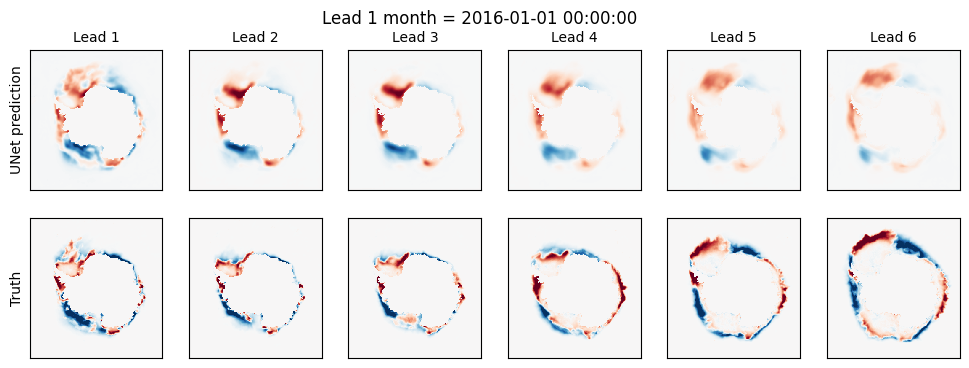

In [56]:
val_time_index = 12 
true_time_index = val_start_index+val_time_index
fig, axs = plt.subplots(figsize=(12,4), nrows=2, ncols=6, sharex=True, sharey=True)

for i in range(6):
    val_pred_ensemble_average = val_preds[:,val_time_index,i,2:-2,2:-2].mean(axis=0)

    axs[0,i].pcolormesh(x, y, val_pred_ensemble_average, cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].pcolormesh(x, y, val_targets[true_time_index,i,:,:], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_title(f"Lead {i+1}", fontsize=10)

axs[0,0].set_ylabel("UNet prediction")
axs[1,0].set_ylabel("Truth")
plt.suptitle(f"Lead 1 month = {prediction_months[true_time_index]}")
plt.savefig(f"../figures/sample_predictions/anomaly_prediction_example.jpg", dpi=300, bbox_inches='tight')

In [3]:
val_preds_anom_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["ens_member", "init_month", "lead", "y", "x"], val_preds_anom[:,:,:,2:-2,2:-2]),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=VAL_MONTHS - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
        ens_member=np.arange(5)
    )
)

val_preds_abs_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["ens_member", "init_month", "lead", "y", "x"], val_preds_abs[:,:,:,2:-2,2:-2]),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=VAL_MONTHS - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
        ens_member=np.arange(5)
    )
)


In [19]:
start_prediction_month = VAL_MONTHS[0]

siconc_anom = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/siconc_anom.nc").siconc
siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
siconc_anom *= ~land_mask

anomaly_to_persist = siconc_anom.sel(time=start_prediction_month - pd.DateOffset(months=1)) 
months_to_predict_clim = siconc_clim.sel(month=pd.date_range(start_prediction_month, \
    start_prediction_month+pd.DateOffset(months=5), freq='MS').month)

prediction = months_to_predict_clim + anomaly_to_persist 

# clip unphysical values outside of [0, 1] 
prediction = prediction.where(prediction < 1, 1)
prediction = prediction.where(prediction > 0, 0)


In [4]:

mae_by_month_and_lead_anom = np.zeros((12, 6))
mae_by_month_and_lead_abs = np.zeros((12, 6))

cell_area = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/NSIDC_SPS_grid_areas.nc").cell_area

for lead in range(1,7): 
    prediction_times = VAL_MONTHS - pd.DateOffset(months=1) + pd.DateOffset(months=lead)
    for target_month in range(1,13):
        # get prediction for anomaly forecast
        val_pred_ens_mean_anom = val_preds_anom_ds.siconc.sel(lead=lead).mean('ens_member')

        init_month = (target_month - lead - 1) % 12 + 1
        val_pred_subset_anom = val_pred_ens_mean_anom.where(val_pred_ens_mean_anom.init_month.dt.month==init_month, drop=True)

        # Add anomaly to climatology to retrieve true sea ice 
        val_pred_subset_anom += siconc_clim.sel(month=target_month)
        val_pred_subset_anom = val_pred_subset_anom.where(val_pred_subset_anom < 1, 1)
        val_pred_subset_anom = val_pred_subset_anom.where(val_pred_subset_anom > 0, 0)
        

        # get prediction for abs forecast
        val_pred_ens_mean_abs = val_preds_abs_ds.siconc.sel(lead=lead).mean('ens_member')
        val_pred_subset_abs = val_pred_ens_mean_abs.where(val_pred_ens_mean_abs.init_month.dt.month==init_month, drop=True)

        # get truth 
        truth = sic_land_masked.sel(time=prediction_times)
        truth = truth.where(truth.time.dt.month==target_month, drop=True)

        # calculate mean error over all times in val set 
        sia_truth = (truth * cell_area).sum(dim=("x", "y")) / 1e12
        sia_pred_anom = (val_pred_subset_anom * cell_area).sum(dim=("x", "y")) / 1e12
        sia_pred_abs = (val_pred_subset_abs * cell_area).sum(dim=("x", "y")) / 1e12

        mae_by_month_and_lead_anom[target_month-1, lead-1] = np.abs(sia_pred_anom.values - sia_truth.values).mean()
        mae_by_month_and_lead_abs[target_month-1, lead-1] = np.abs(sia_pred_abs.values - sia_truth.values).mean()



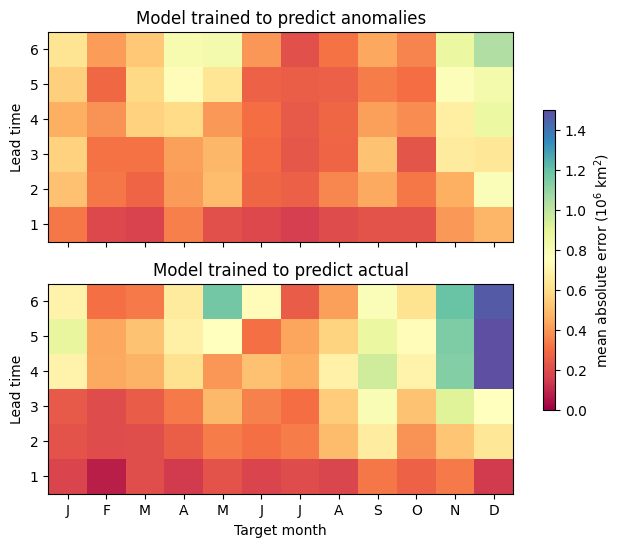

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0].pcolormesh(x, y, mae_by_month_and_lead_anom.T, cmap='Spectral', shading='flat', vmin=0, vmax=1.5)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title("Model trained to predict anomalies")

axs[1].pcolormesh(x, y, mae_by_month_and_lead_abs.T, cmap='Spectral', shading='flat', vmin=0, vmax=1.5)
axs[1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_xlabel("Target month")
axs[1].set_ylabel("Lead time")
axs[1].set_title("Model trained to predict actual")

cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
plt.colorbar(cax, cax=cbar_ax, label=r'mean absolute error (10$^6$ km$^2$)', orientation='vertical')
plt.savefig("../figures/anomaly_vs_abs_pred_forecast_MAE.jpg", dpi=300, bbox_inches='tight')

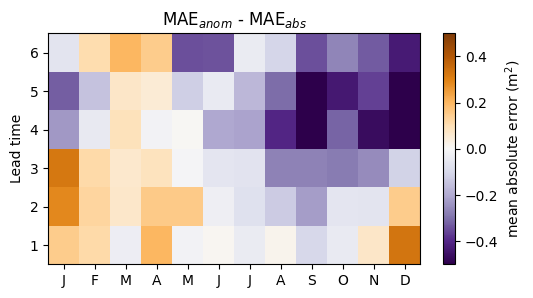

In [264]:
plt.figure(figsize=(6,3))

plt.pcolormesh(x, y, (mae_by_month_and_lead_anom - mae_by_month_and_lead_abs).T, cmap='PuOr_r', shading='flat', vmin=-0.5, vmax=0.5)
plt.yticks(y_centers, labels=np.arange(1,7,1))
plt.xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.ylabel("Lead time")
plt.title(r"MAE$_{anom}$ - MAE$_{abs}$")
plt.colorbar(label=r'mean absolute error (m$^2$)')
plt.savefig("../figures/anomaly_vs_abs_pred_forecast_diff.jpg", dpi=300, bbox_inches='tight')


In [4]:
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=6+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=12+1), '2024-01', freq='MS')
start_prediction_months = first_range.append(second_range)

targets = h5py.File(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/targets.h5", 'r')["targets_sea_ice_only"]

land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
linear_forecast = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/linear_forecasts/linear_forecast_all_years.nc").siconc
linear_forecast = linear_forecast.rename({"xgrid": "x", "ygrid": "y"})
linear_forecast = linear_forecast.where(~land_mask, 0)

mse = np.zeros(start_prediction_months.shape)

split_array = np.empty(np.shape(start_prediction_months), dtype=object)
for i,month in enumerate(start_prediction_months):
    months = pd.date_range(month, month + pd.DateOffset(months=5), freq="MS")

    if month in TRAIN_MONTHS: 
        split_array[i] = "train"
    if month in VAL_MONTHS: 
        split_array[i] = "val"
    if month in TEST_MONTHS: 
        split_array[i] = "test"

    # calculate MSE  
    x_pred = linear_forecast.sel(time=months).values
    mse[i] = calc_masked_MSE_loss(targets[i,:,:,:], x_pred, target_months=months.month)

print(f"Loss (modified MSE) of linear forecast for train months: {mse[split_array=='train'].mean()}")
print(f"Loss (modified MSE) of linear forecast for val months: {mse[split_array=='val'].mean()}")
print(f"Loss (modified MSE) of linear forecast for test months: {mse[split_array=='test'].mean()}")



Loss (modified MSE) of linear forecast for train months: 0.033626363722090484
Loss (modified MSE) of linear forecast for val months: 0.0331073455533756
Loss (modified MSE) of linear forecast for test months: 0.02972224404399473


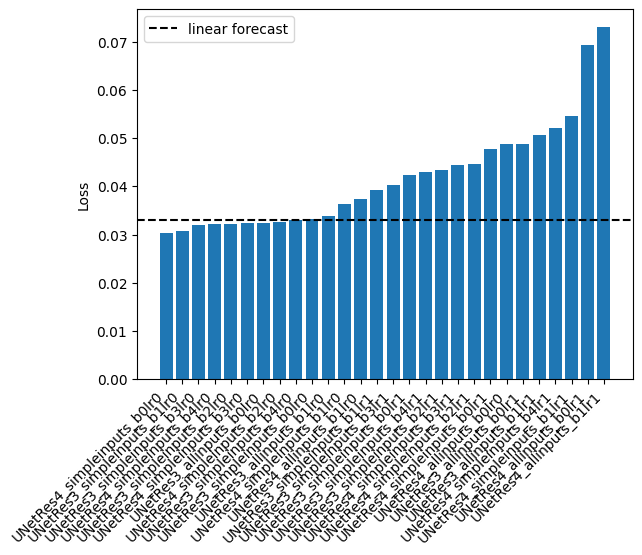

In [12]:

batch_sizes = [16, 32, 4, 2, 1]
learning_rates = [1e-4, 1e-5]
input_configs = ["simple", "all"]
architectures = ["UNetRes3", "UNetRes4"]

val_losses = {}
for i,b in enumerate(batch_sizes):
    for j,lr in enumerate(learning_rates):
        for input_config in input_configs:
            for arch in architectures: 
                model_name = f"{arch}_{input_config}inputs_b{i}lr{j}"
                if os.path.exists(f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pkl"):
                    model_config_dict = load_pickle(f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pkl")
                    val_losses[model_name] = model_config_dict["best_val_loss"]

sorted_val_losses = sorted(val_losses.items(), key=lambda item: item[1])
labels, values = zip(*sorted_val_losses)

plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.axhline(y = mse[split_array=='val'].mean(), linestyle='dashed', label='linear forecast', color='k')
plt.legend()
plt.ylabel("Loss")
plt.savefig("../figures/prelim_hyperparam_sweep.jpg", dpi=300, bbox_inches='tight')


In [6]:
best_model = labels[0]
val_pred = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/{best_model}_val_predictions.npy")

nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
sic_land_masked = nsidc_sic.siconc.where(~land_mask, 0)

val_pred_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["time", "lead", "y", "x"], val_pred[:,:,2:334,2:318]),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        time=VAL_MONTHS,
        lead=np.arange(1,7,1)
    )
)

val_pred = val_pred_ds.siconc
val_and_test_months = VAL_MONTHS.append(TEST_MONTHS)

In [9]:
cell_area = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/NSIDC_SPS_grid_areas.nc").cell_area

sia_truth = (sic_land_masked * cell_area).sum(dim=("x", "y")) / 1e12
sie_truth = (cell_area.where(sic_land_masked > 0.15)).sum(dim=("x","y")) / 1e12

sia_pred = (val_pred * cell_area).sum(dim=("x", "y")) / 1e12
sie_pred = (cell_area.where(val_pred > 0.15)).sum(dim=("x","y")) / 1e12

#linear_forecast = linear_forecast.rename({"xgrid": "x", "ygrid": "y"}) 
sia_lin = (linear_forecast * cell_area).sum(dim=("x","y")) / 1e12 
sie_lin = (cell_area.where(linear_forecast > 0.15)).sum(dim=("x","y")) / 1e12 


Text(0, 0.5, 'Absolute error (10$^6$ km$^2$)')

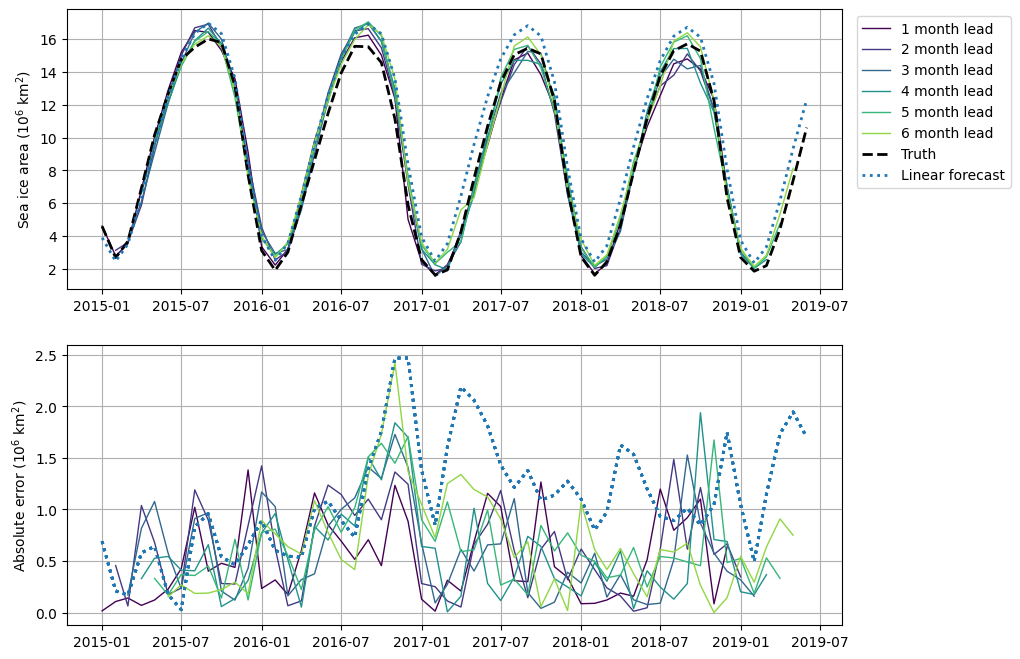

In [145]:
import matplotlib.cm 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

months = val_and_test_months[0:48+6]
ax1.grid()

cmap = matplotlib.cm.viridis 

for lead_time in range(6):
    target_months = months[lead_time:-(6-lead_time)]
    ax1.plot(target_months, sia_pred.sel(lead=lead_time+1), linewidth=1, color=cmap(lead_time/6), label=f'{lead_time+1} month lead')
    
    mae_pred = np.abs(sia_pred.sel(lead=lead_time+1).data - sia_truth.sel(time=target_months).data)
    mae_lin = np.abs(sia_lin.sel(time=months).data - sia_truth.sel(time=months).data)

    ax2.plot(target_months, mae_pred, linewidth=1, color=cmap(lead_time/6))
    ax2.plot(months, mae_lin, linewidth=2, color='tab:blue', linestyle='dotted')

ax1.plot(months, sia_truth.sel(time=months), color='k', linewidth=2, linestyle='dashed', label='Truth')
ax1.plot(months, sia_lin.sel(time=months), color='tab:blue', linewidth=2, linestyle='dotted', label='Linear forecast')
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

ax1.set_ylabel(r"Sea ice area (10$^6$ km$^2$)")

ax2.grid()
ax2.set_ylabel(r"Absolute error (10$^6$ km$^2$)")

#plt.savefig(f"../figures/SIA_comparison_{best_model}.jpg", dpi=300, bbox_inches='tight')

In [28]:
model_config_dict = load_pickle(f"{DATA_DIRECTORY}/sicpred/models/UNetRes4_simpleinputs_b2lr0.pkl")
model_config_dict

{'name': 'UNetRes4_simpleinputs_b2lr0',
 'architecture': 'UNetRes4',
 'input_config': 'simple',
 'batch_size': 4,
 'lr': 0.0001,
 'optimizer': 'adam',
 'use_zeros_weight': False,
 'zeros_weight': None,
 'early_stopping': True,
 'patience': 10,
 'max_epochs': 100,
 'notes': '',
 'best_val_loss': 0.03252369553471605,
 'final_epoch': 12}

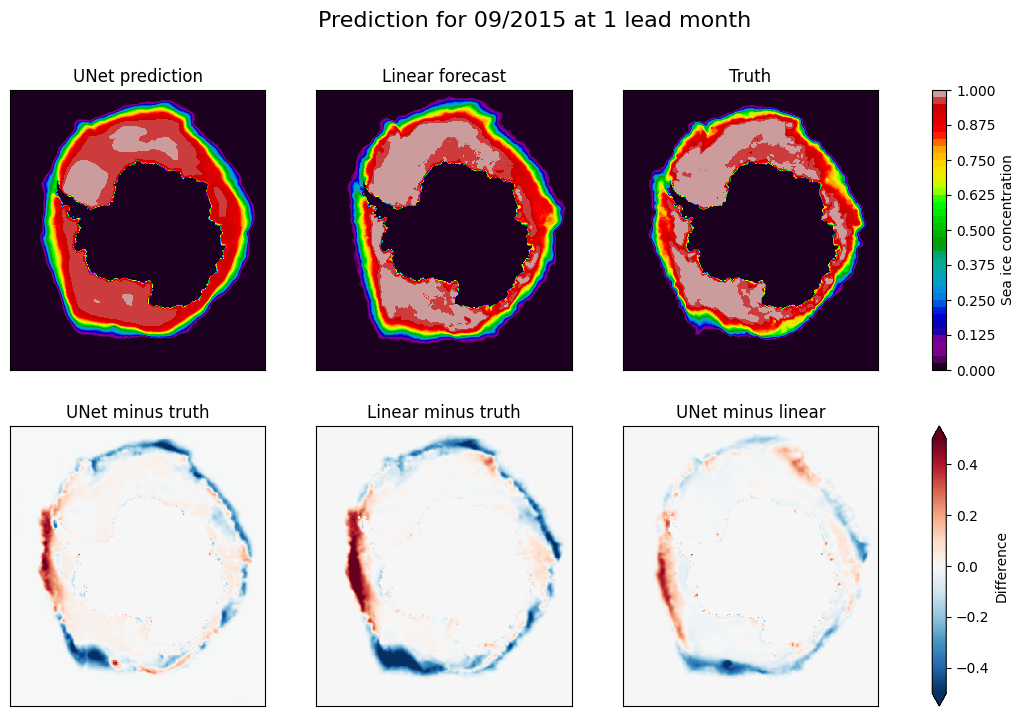

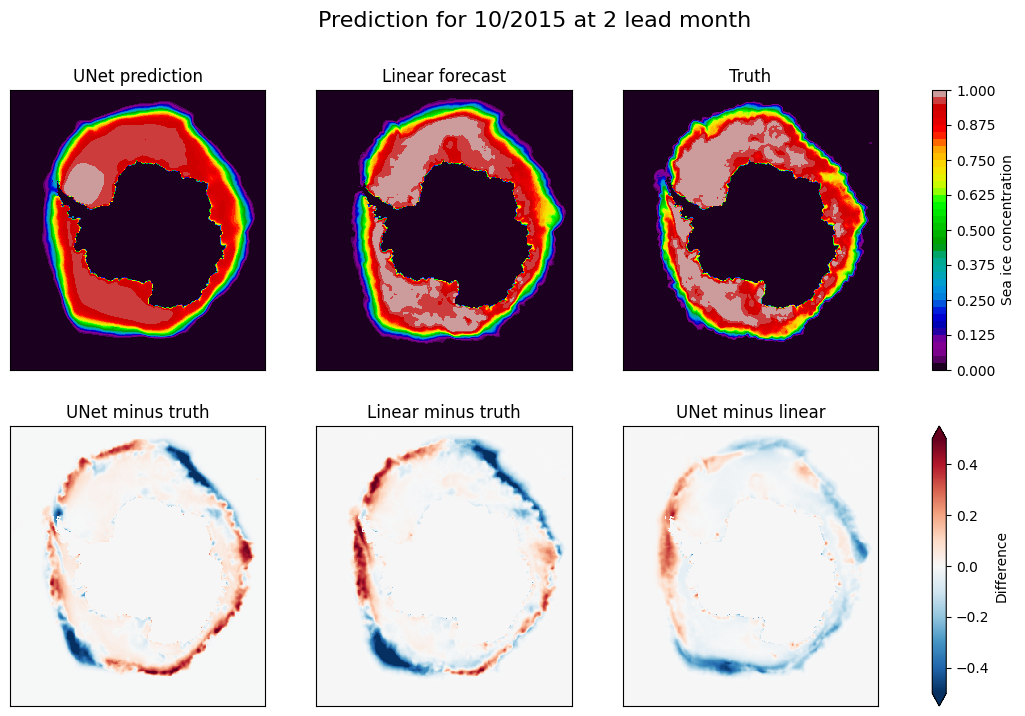

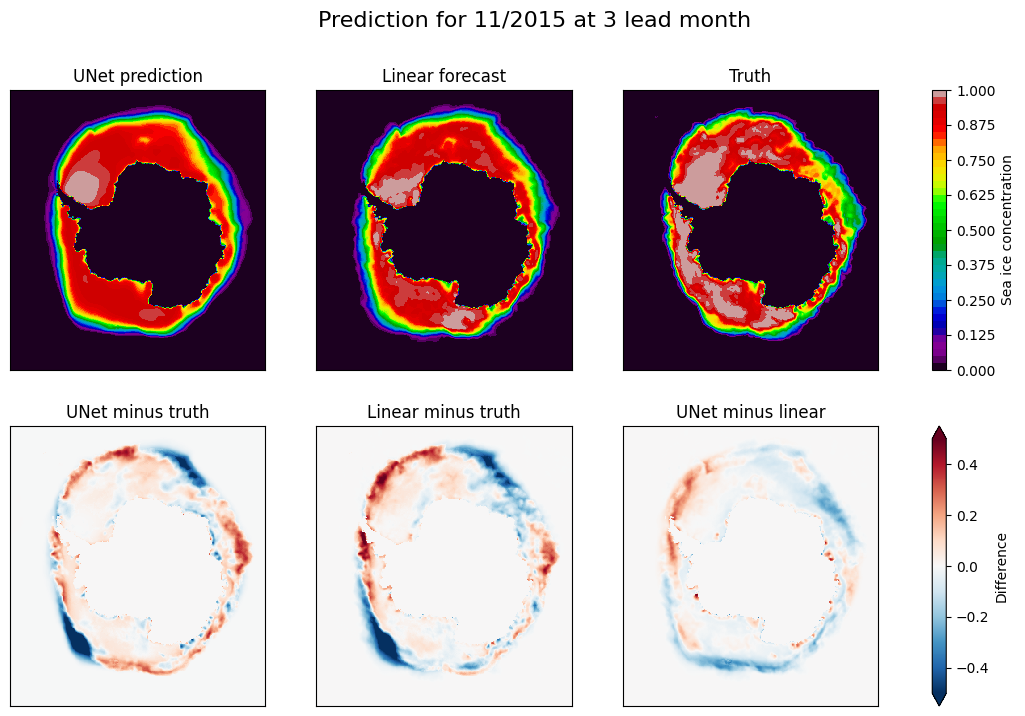

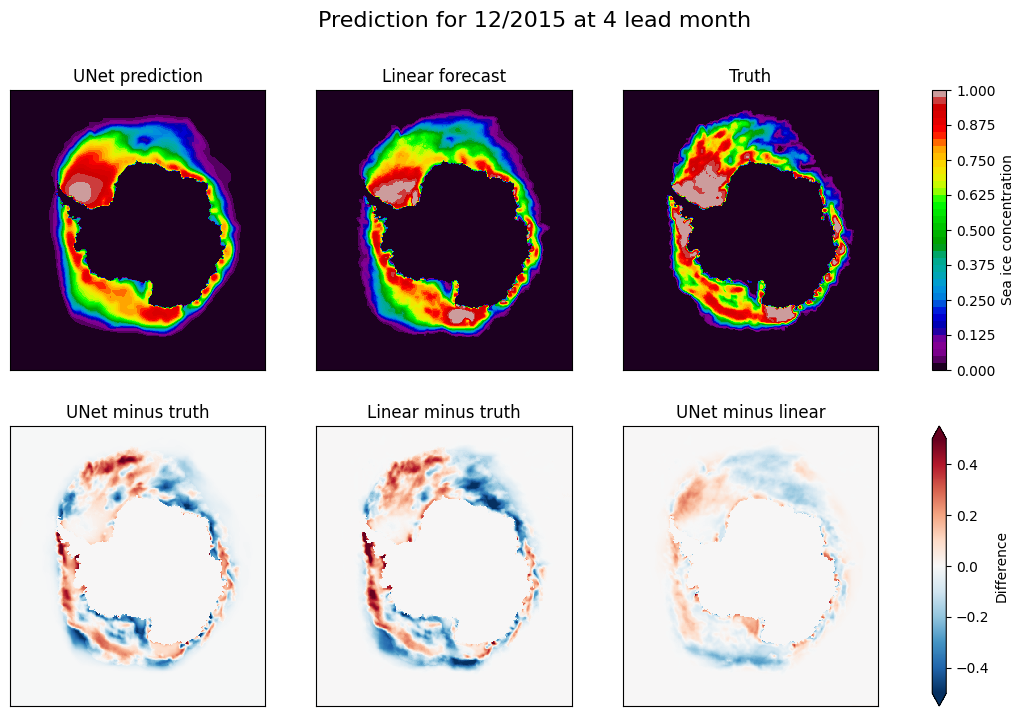

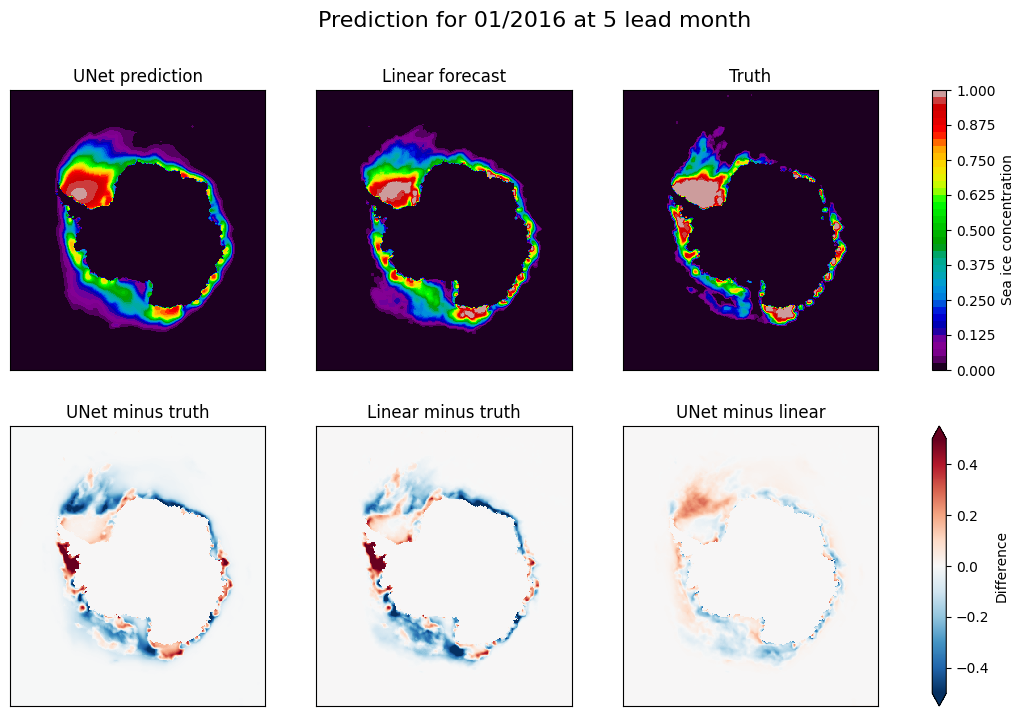

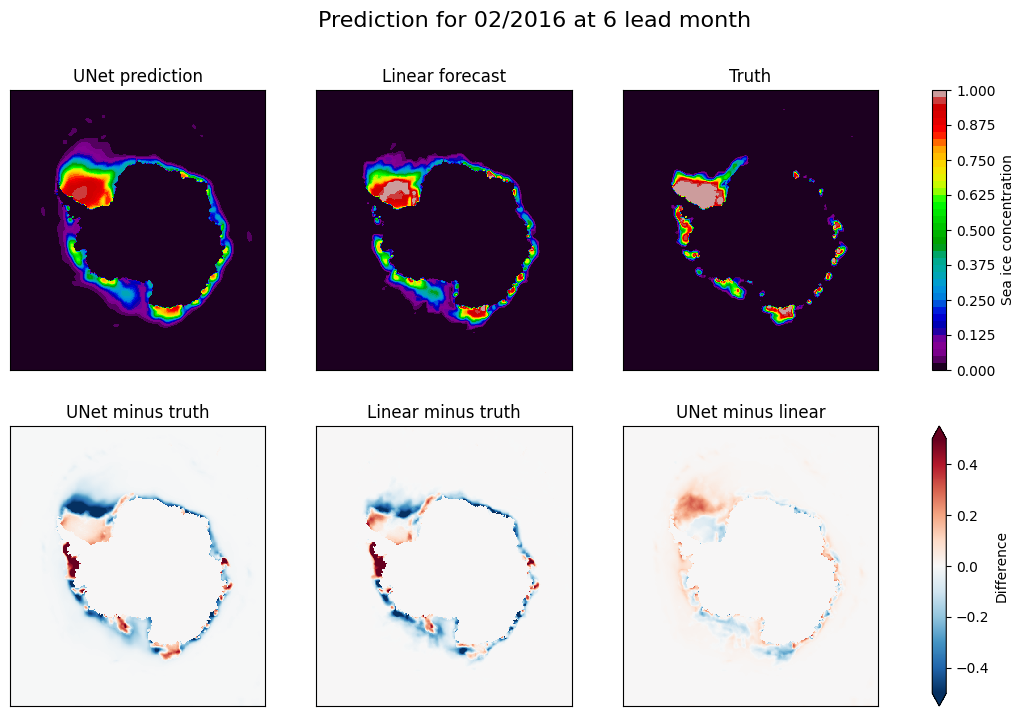

In [23]:

init_index = 8
lead_time = 0
for lead_time in range(6):
    fig, axs = plt.subplots(2, 3, figsize=(14,8))

    prediction = val_pred[init_index,lead_time,:,:]
    target_month = val_and_test_months[init_index + lead_time]
    truth = sic_land_masked.sel(time=target_month)

    # grid params
    x = nsidc_sic.xgrid / 1e6
    y = nsidc_sic.ygrid / 1e6 

    # Plot prediction
    axs[0,0].contourf(x, y, prediction, cmap='nipy_spectral', levels=np.arange(0,1.025,0.025))

    # Plot linear forecast
    linear_forecast_prediction = linear_forecast.sel(time=target_month)
    axs[0,1].contourf(x, y, linear_forecast_prediction, cmap='nipy_spectral', levels=np.arange(0,1.025,0.025))

    # Plot truth
    cax = axs[0,2].contourf(x, y, truth, cmap='nipy_spectral', levels=np.arange(0,1.025,0.025))

    # Plot anomalies
    axs[1,0].pcolormesh(x, y, truth-prediction, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axs[1,1].pcolormesh(x, y, truth-linear_forecast_prediction, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    cax2 = axs[1,2].pcolormesh(x, y, prediction-linear_forecast_prediction, cmap='RdBu_r', vmin=-0.5, vmax=0.5)

    axs[0,0].set_title("UNet prediction")
    axs[0,1].set_title("Linear forecast")
    axs[0,2].set_title("Truth")

    axs[1,0].set_title("UNet minus truth")
    axs[1,1].set_title("Linear minus truth")
    axs[1,2].set_title("UNet minus linear")

    # Plot colorbars
    cbar = fig.colorbar(cax, ax=axs[0,:], orientation='vertical')
    cbar.set_label('Sea ice concentration')

    cbar2 = fig.colorbar(cax2, ax=axs[1,:], orientation='vertical', extend='both')
    cbar2.set_label('Difference')

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(rf"Prediction for {target_month.month:02}/{target_month.year} at {lead_time+1} lead month", fontsize=16)
    os.makedirs(f"../figures/sample_predictions/{model_name}", exist_ok=True)
    plt.savefig(f"../figures/sample_predictions/{model_name}/{target_month.month:02}-{target_month.year}_lead{lead_time+1}.jpg", dpi=300, bbox_inches='tight')